# Recommender Systems

we will use RBMs to build a recommender system, one of
the most successful applications of machine learning to date and widely
used in industry to help predict user preferences for movies, music, books,
news, search, shopping, digital advertising, and online dating.
There are two major categories of recommender systems—collaborative
filtering recommender systems and content-based filtering recommender
systems. Collaborative filtering involves building a recommender system
from a user’s past behavior and those of other users to which the user is
similar to. This recommender system can then predict items that the user
may have an interest in even though the user has never expressed explicit
interest. Movie recommendations on Netflix rely on collaborative filtering.
Content-based filtering involves learning the distinct properties of an item
to recommend additional items with similar properties. Music
recommendations on Pandora rely on content-based filtering.

# Collaborative Filtering

Content-based filtering is not commonly used because it is a rather difficult
task to learn the distinct properties of items—this level of understanding is
very challenging for artificial machines to achieve currently. It is much
easier to collect and analyze a large amount of information on users’
behaviors and preferences and make predictions based on this. Therefore,
collaborative filtering is much more widely used and is the type of
recommender system we will focus on here.

Collaborative filtering requires no knowledge of the underlying items
themselves. Rather, collaborative filtering assumes that users that agreed in
the past will agree in the future and that user preferences remain stable over
time. By modeling how similar users are to other users, collaborative
filtering can make pretty powerful recommendations. Moreover,
collaborative filtering does not have to rely on explicit data (i.e., ratings that
users provide). Rather, it can work with implicit data such as how long or
how often a user views or clicks on a particular item. For example, in the
past Netflix asked users to rate movies but now uses implicit user behavior
to make inferences about user likes and dislikes.

However, collaborative filtering has its challenges. First, it requires a lot of
user data to make good recommendations. Second, it is a very
computationally demanding task. Third, the datasets are generally very
sparse since users will have exhibited preferences for only a small fraction
of all the items in the universe of possible items. Assuming we have enough
data, there are techniques we can use to handle the sparsity of the data and
efficiently solve the problem, which we will cover in this chapter.

# MovieLens Dataset

Instead of the 100 million ratings Netflix dataset, we will use a smaller
movie ratings dataset known as the MovieLens 20M Dataset, provided by
GroupLens, a research lab in the Department of Computer Science and
Engineering at the University of Minnesota, Twin Cities. The data contains
20,000,263 ratings across 27,278 movies created by 138,493 users from
January 9, 1995 to March 31, 2015. Of users who rated at least 20 movies
each, we will select a subset at random.
This dataset is more manageable to work with than the 100 million ratings
dataset from Netflix. Because the file size exceeds one hundred megabytes,
the file is not accessible on GitHub. You will need to download the file
directly from the MovieLens website.

In [2]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime

now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
import lightgbm as lgb


import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

# Load the data

In [3]:
ratingDF = pd.read_csv('../input/movielens-20m-dataset/ratings.csv')

# Convert fields into appropriate data types

In [8]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,"04/20/2024, 17:21:15"
1,1,29,3.5,"04/20/2024, 17:21:15"
2,1,32,3.5,"04/20/2024, 17:21:15"
3,1,47,3.5,"04/20/2024, 17:21:15"
4,1,50,3.5,"04/20/2024, 17:21:15"


In [4]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: now.strftime("%m/%d/%Y, %H:%M:%S"))

In [5]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

In [6]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


In [7]:
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
"rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [9]:
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
"rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

Let’s also reindex movieID and userID to a range of 1 to 1,000 for our
reduced dataset:

In [10]:
#mapping original movie ID's form dataframe to the new convenient movie ID's we are going to use
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1

In [12]:
#similarly for users
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

In [13]:
'''The left_on and right_on parameters are used in Pandas' merge() function to specify 
the columns used for merging when the names of the columns are different 
in the left and right DataFrames being merged.'''

ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)

Let’s calculate the number of unique users, unique movies, total ratings, and
average number of ratings per user for our reduced dataset:

In [14]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

In [15]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


Let’s generate a test set and a validation set from this reduced dataset so
that both of them are 5% of the reduced dataset:

In [20]:
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,"04/20/2024, 17:21:15",1,1
1,49,163,3.5,"04/20/2024, 17:21:15",2,1
2,49,216,3.0,"04/20/2024, 17:21:15",3,1
3,49,296,5.0,"04/20/2024, 17:21:15",4,1
4,49,333,3.0,"04/20/2024, 17:21:15",5,1


In [16]:
X_train, X_test = train_test_split(ratingDFX3,
test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test,
test_size=0.50, shuffle=True, random_state=2018)

In [17]:
print('Shape of train set:', X_train.shape)
print('Shape of validation set:',X_validation.shape)
print('Shape of test set: ',X_test.shape)

Shape of train set: (81191, 6)
Shape of validation set: (4511, 6)
Shape of test set:  (4511, 6)


In [18]:
print('Size of train set:', X_train.size)
print('Size of validation set:',X_validation.size)
print('Size of test set: ',X_test.size)

Size of train set: 487146
Size of validation set: 27066
Size of test set:  27066


## Define the Cost Function: Mean Squared Error

In [21]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [22]:
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.12%


In [23]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [24]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

# Perform Baseline Experiments

In [25]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [26]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5
pred_validation

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

In [27]:
print("Mean  Squared Error is : ", mean_squared_error(pred_validation, actual_validation))

Mean  Squared Error is :  1.055420084238528


In [28]:
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [29]:
pred_validation = ratings_validation_prediction  [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.9090717929472647


In [30]:
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

In [31]:
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.9136057106858655


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train, X_validation, and X_test are tensors
train_dataset = TensorDataset(torch.tensor(X_train.newUserId.values), 
                              torch.tensor(X_train.newMovieId.values),
                              torch.tensor(X_train.rating.values))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_validation.newUserId.values), 
                            torch.tensor(X_validation.newMovieId.values),
                            torch.tensor(X_validation.rating.values))
val_loader = DataLoader(val_dataset, batch_size=64)

class CollaborativeFiltering(nn.Module):
    def __init__(self, n_users, n_movies, n_latent_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_embedding = nn.Embedding(n_users + 1, n_latent_factors)
        self.movie_embedding = nn.Embedding(n_movies + 1, n_latent_factors)

    def forward(self, user_ids, movie_ids):
        user_embedding = self.user_embedding(user_ids)
        movie_embedding = self.movie_embedding(movie_ids)
        
        # Flatten embeddings
        user_embedding = user_embedding.view(-1, 1)
        movie_embedding = movie_embedding.view(-1, 1)

        # Compute dot product
        dot_product = torch.sum(user_embedding * movie_embedding, dim=1)
        return dot_product


In [34]:
# Initialize model
n_latent_factors = 1
model = CollaborativeFiltering(n_users, n_movies, n_latent_factors)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:
# Training loop
train_losses = []
val_losses = []
for epoch in range(100):
    model.train()
    train_loss = 0.0
    for user_ids, movie_ids, ratings in train_loader:
        optimizer.zero_grad()
        predictions = model(user_ids, movie_ids)
        loss = criterion(predictions, ratings.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * user_ids.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for user_ids, movie_ids, ratings in val_loader:
            predictions = model(user_ids, movie_ids)
            loss = criterion(predictions, ratings.float())
            val_loss += loss.item() * user_ids.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{100}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100, Train Loss: 14.9759, Val Loss: 14.6674
Epoch 2/100, Train Loss: 14.7252, Val Loss: 14.5150
Epoch 3/100, Train Loss: 14.5433, Val Loss: 14.4001
Epoch 4/100, Train Loss: 14.3908, Val Loss: 14.2851
Epoch 5/100, Train Loss: 14.2207, Val Loss: 14.1169
Epoch 6/100, Train Loss: 13.9532, Val Loss: 13.7821
Epoch 7/100, Train Loss: 13.4227, Val Loss: 13.0625
Epoch 8/100, Train Loss: 12.3556, Val Loss: 11.6594
Epoch 9/100, Train Loss: 10.5503, Val Loss: 9.5439
Epoch 10/100, Train Loss: 8.2531, Val Loss: 7.2196
Epoch 11/100, Train Loss: 6.0866, Val Loss: 5.3002
Epoch 12/100, Train Loss: 4.4618, Val Loss: 3.9572
Epoch 13/100, Train Loss: 3.3547, Val Loss: 3.0485
Epoch 14/100, Train Loss: 2.6031, Val Loss: 2.4196
Epoch 15/100, Train Loss: 2.0829, Val Loss: 1.9758
Epoch 16/100, Train Loss: 1.7157, Val Loss: 1.6570
Epoch 17/100, Train Loss: 1.4529, Val Loss: 1.4259
Epoch 18/100, Train Loss: 1.2632, Val Loss: 1.2590
Epoch 19/100, Train Loss: 1.1249, Val Loss: 1.1381
Epoch 20/100, Train Los

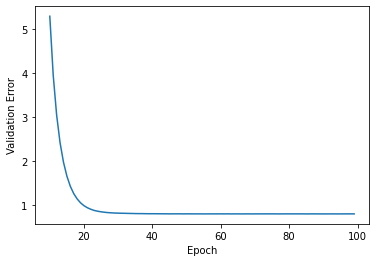

Minimum MSE: 0.7962481508337456


In [36]:
# Plot validation error
import matplotlib.pyplot as plt
plt.plot(range(10, 100), val_losses[10:])
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
plt.show()

print('Minimum MSE:', min(val_losses))


In [42]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

# Convert test set into DataLoader
test_dataset = TensorDataset(torch.tensor(X_test.newUserId.values), 
                             torch.tensor(X_test.newMovieId.values),
                             torch.tensor(X_test.rating.values))
test_loader = DataLoader(test_dataset, batch_size=64)

# Calculate predictions for test set
test_predictions = []
model.eval()
with torch.no_grad():
    for user_ids, movie_ids, ratings in test_loader:
        predictions = model(user_ids, movie_ids)
        test_predictions.extend(predictions.tolist())

# Flatten actual ratings and predicted ratings
actual_test = ratings_test[ratings_test.nonzero()].flatten()
pred_test = np.array(test_predictions)

# Calculate Mean Squared Error
test_mse = mean_squared_error(pred_test, actual_test)
print("Mean Squared Error for test set:", test_mse)


Mean Squared Error for test set: 1.448600493863178


In [38]:
import numpy as np

# Assuming user_id is the ID of the randomly selected user
user_id = np.random.randint(1, n_users + 1)  # Randomly select a user ID
print("Selected User ID:", user_id)

# Create a tensor for the selected user ID and all movie IDs
user_ids = torch.full((len(movies),), user_id, dtype=torch.long)
movie_ids = torch.arange(1, len(movies) + 1, dtype=torch.long)

# Get the predicted ratings for all movies by the selected user
predicted_ratings = model(user_ids, movie_ids).detach().numpy()

# Sort the movies based on their predicted ratings
sorted_movie_indices = np.argsort(predicted_ratings)[::-1]  # Sort in descending order

# Select the top 5 movies with the highest predicted ratings
top_5_movie_indices = sorted_movie_indices[:5]
top_5_movies = moviesDF.iloc[top_5_movie_indices]['originalMovieId'].values

print("Top 5 movie suggestions for the user:")
for i, movie_id in enumerate(top_5_movies, 1):
    print(f"{i}. Movie ID: {movie_id}")


Selected User ID: 341
Top 5 movie suggestions for the user:
1. Movie ID: 898
2. Movie ID: 2019
3. Movie ID: 1256
4. Movie ID: 1284
5. Movie ID: 306
